In [1]:
import tensorflow as tf
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

from constants import Constants
from model import Network
from loss import get_loss_function
from sampler import get_batch_sampler
from visualizer import Visualizer

2026-01-15 19:17:57.679856: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-01-15 19:17:57.679879: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-15 19:17:57.679884: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-01-15 19:17:57.679897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-15 19:17:57.679913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-15 19:17:57.684735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [2]:
@tf.function
def a_function(x: tf.Tensor, t: tf.Tensor) -> tf.Tensor:
    return 5 * (tf.constant(0.4) - x)


constants = Constants(
    sigma=0.61,
    T=1.,
    X_0=-0.3,
    a_function=a_function,
    lam=3.,
    DL=True,
    DW_AND_DL=False,
    N = 2**9,
)

In [3]:
network = Network(
    n_points=constants.N,
    initial_value=constants.X_0,
    derivative_initial_value=constants.dX_0,
    sigma=constants.sigma,
    end_time=constants.T,
)

In [4]:
tf.random.set_seed(7)
batch_size = 64
N_EPOCHS = 4_000
save_model_after = 1000
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate)

loss_function = get_loss_function(
    constants.T, constants.f_function
)
sample_batch = get_batch_sampler(
    constants.T, constants.N, constants.sigma,
    lam=constants.lam, DL=constants.DL, DW_AND_DL=constants.DW_AND_DL
)

In [5]:
@tf.function(reduce_retracing=True)
def train_step(model: keras.Model, x: tf.Tensor):
    with tf.GradientTape() as tape:
        loss = loss_function(model, x)
    grads = tape.gradient(loss, model.trainable_variables)
    grads_vars = [
        (g, v) for g, v in zip(grads, model.trainable_variables)
        if g is not None
    ]
    optimizer.apply_gradients(grads_vars)
    return loss

In [6]:
losses = []
for step in tqdm(list(range(1, N_EPOCHS + 1))):
    x_batch = sample_batch(batch_size=batch_size, random=True)
    loss_val = train_step(network, x_batch)
    losses.append(loss_val)
    if step % save_model_after == 0:
        network.save(f"models/n{constants.N}/model_{step}.keras")

100%|██████████| 4000/4000 [01:17<00:00, 51.46it/s]


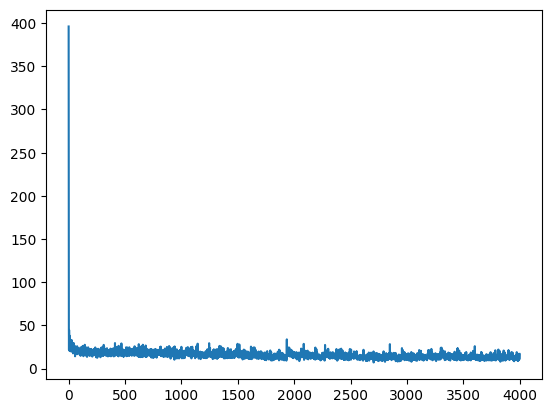

In [7]:
plt.plot(losses)
# plt.ylim(0,3)
plt.show()

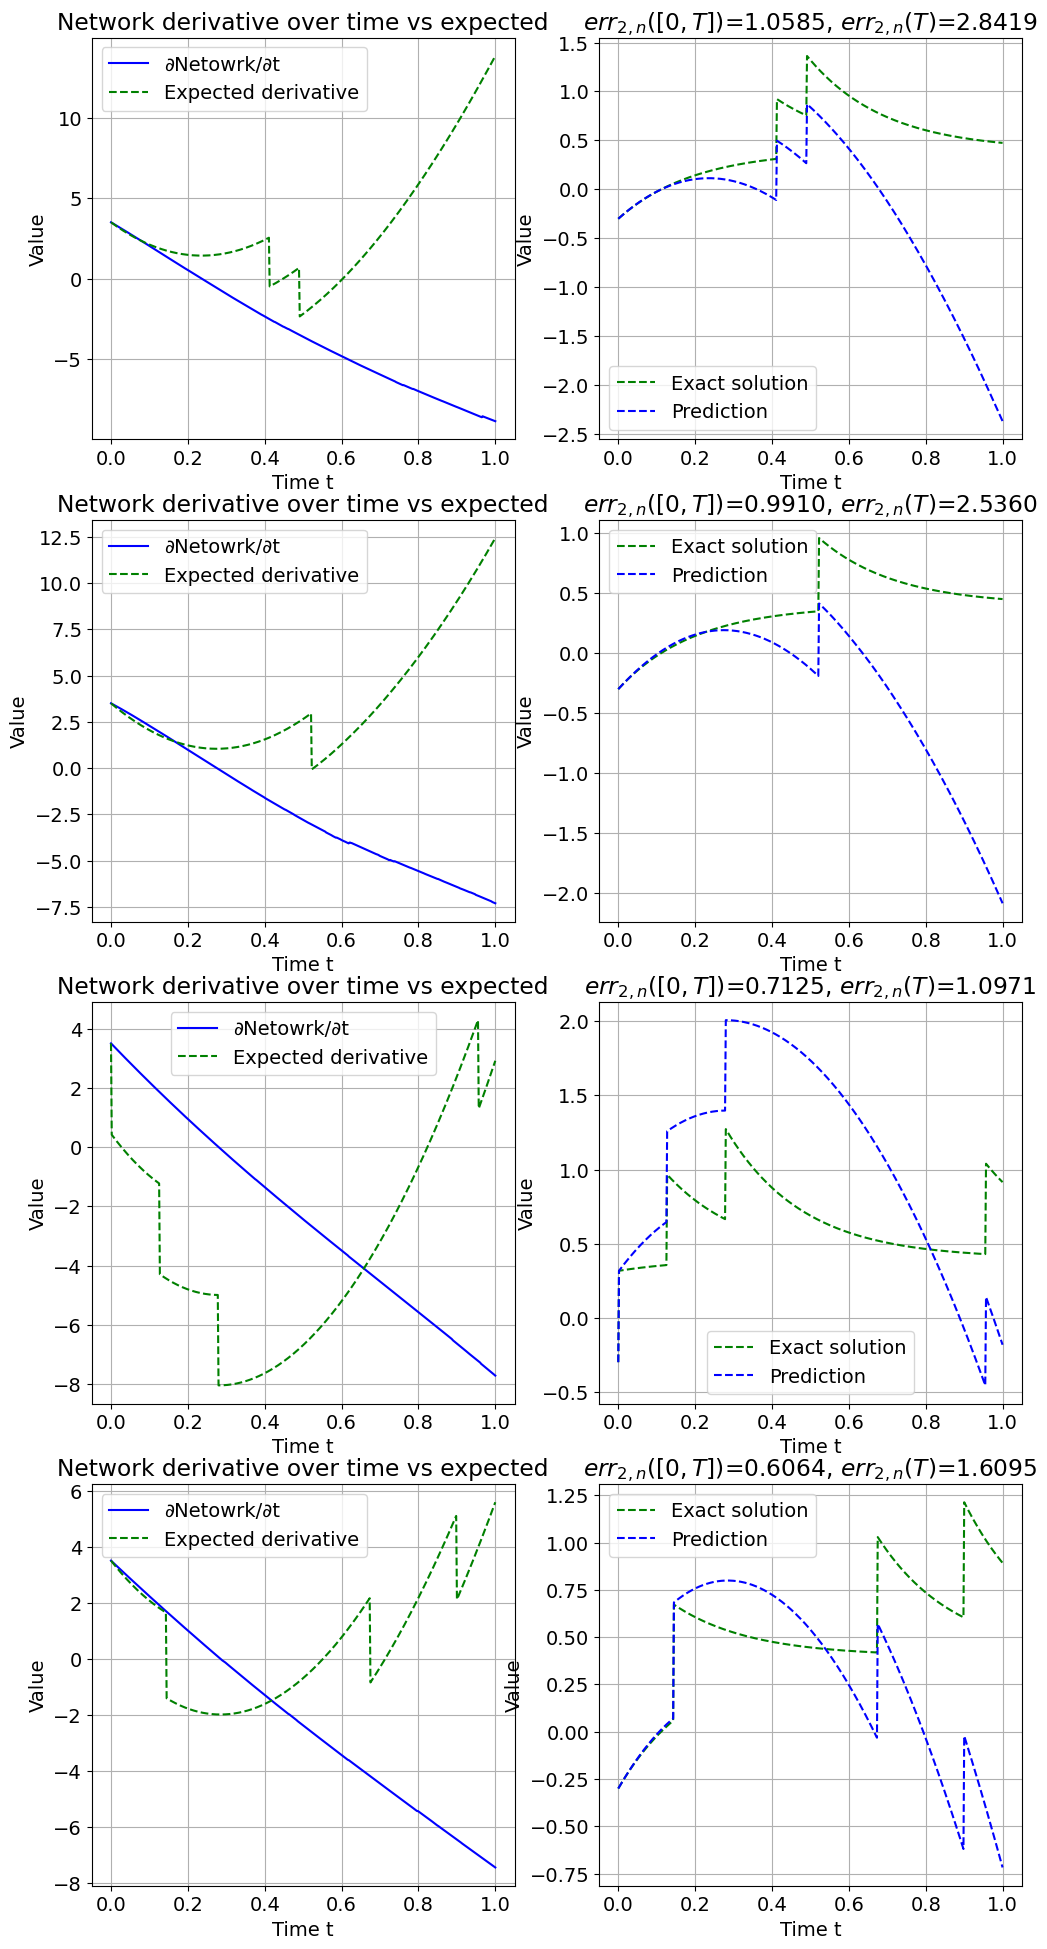

In [8]:
plt.rcParams.update({'font.size': 14})

x_batch = sample_batch(batch_size=4, random=False)
visualizer = Visualizer(constants)
visualizer.visualize(x_batch[:, 1:], network)